# Aula 2 - Parte Prática - Policy Gradients 

## Introdução

Nesse segundo notebook vamos aprender ...

### Objetivos:

- Entender a abordagem de otimização de políticas como busca no espaço de parâmetros da política
- Implementar um primeiro agente baseado no algoritmo REINFORCE
- Familiarizar-se com a API básica de construção de modelos (i.e., redes neurais) em Keras
- Familiarizar-se com métodos de Deep Learning usando TensorFlow 2.X

### Imports

> **Atenção:** não se esqueça de executar todos os `imports` necessários antes prosseguir com o tutorial.

In [1]:
import gym
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from utils.agent import RLAgent
from utils.memory import OnPolicyReplay

In [2]:
# sanity check
assert tf.__version__ == '2.1.0'
assert tf.executing_eagerly()

## 1. Implementando políticas estocásticas em tf.Keras 

In [3]:
tfd = tfp.distributions

### 1.1 Caso discreto

In [4]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, input_shape=(5,), activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(3),
    tfp.layers.DistributionLambda(lambda t: tfd.Categorical(logits=t))
])

In [5]:
inputs = tf.random.normal(shape=(10, 5))
print(inputs)

tf.Tensor(
[[ 0.2561836  -0.08687838  0.8175645   1.0910985  -1.463611  ]
 [-0.23010162  0.30058995  0.76816005 -0.00634777 -0.07983074]
 [-0.39090845 -0.15990222  0.73605406  0.03648826  1.0746176 ]
 [ 1.4153752   1.285174    0.04278083 -2.1348433  -0.01232369]
 [-0.16007245  1.3788239  -0.7652767  -0.8594494  -0.02964959]
 [-0.8586642   0.36516076  0.7698301   1.4887937   1.1037723 ]
 [-0.05311968  0.34171683 -0.68178433 -1.3650879  -0.12716934]
 [ 0.02167852  0.19407853 -0.9697222  -0.4512258  -0.68772024]
 [-0.03168175 -1.573495   -1.3480132   0.2967591   0.6607458 ]
 [ 0.536796    2.1479301   0.39222777 -0.944838   -0.27735597]], shape=(10, 5), dtype=float32)


In [6]:
dist = model(inputs)
print(dist)

tfp.distributions.Categorical("sequential_distribution_lambda_Categorical", batch_shape=[10], event_shape=[], dtype=int32)


In [7]:
sample = dist.sample()
print(sample)

tf.Tensor([2 0 2 1 1 2 1 2 2 1], shape=(10,), dtype=int32)


In [8]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor(
[-1.0021378  -1.1846218  -0.88076967 -1.6820474  -1.5406334  -0.85117406
 -1.2855558  -0.8333774  -0.9499204  -1.641747  ], shape=(10,), dtype=float32)


In [9]:
def build_discrete_policy(obs_space, action_space, hidden_layers, activation="relu"):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    Categorical = tfd.Categorical
    
    policy_net_layers = []

    policy_net_layers.append(Input(shape=obs_space.shape, name="State"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))
    
    policy_net_layers.append(Dense(units=action_space.n, name="Logits"))
    policy_net_layers.append(DistributionLambda(lambda t: Categorical(logits=t), name="Action_Distribution_Categorical"))
                                     
    return tf.keras.Sequential(policy_net_layers)


In [10]:
env = gym.make("MountainCar-v0")

hidden_layers = [64, 64]
activation = "relu"

policy = build_discrete_policy(env.observation_space, env.action_space, hidden_layers, activation)

obs = env.observation_space.sample()

action_dist = policy(obs[None,:])
print(action_dist)
print(action_dist.sample())

action = action_dist.sample().numpy()
assert action[0] in env.action_space

tfp.distributions.Categorical("sequential_1_Action_Distribution_Categorical_Categorical", batch_shape=[1], event_shape=[], dtype=int32)
tf.Tensor([1], shape=(1,), dtype=int32)


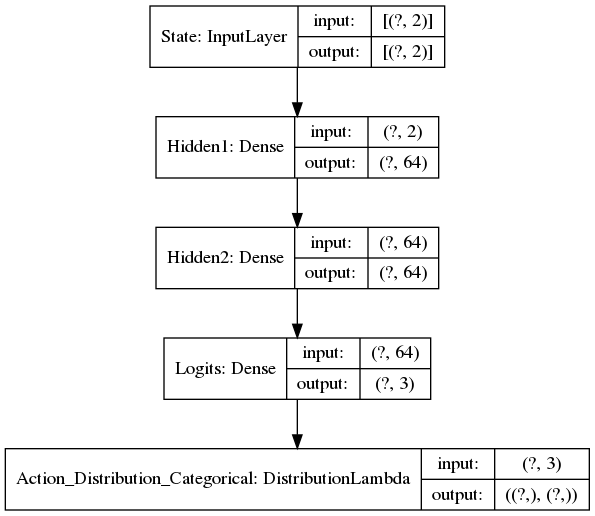

In [11]:
tf.keras.utils.plot_model(policy, show_shapes=True)

### 1.2 Caso contínuo 

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation="tanh", input_shape=(10,)),
    tf.keras.layers.Dense(128, activation="tanh"),
    tf.keras.layers.Dense(10),
    tfp.layers.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(loc=t, scale_diag=[1e-2] * 10))
])

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [13]:
inputs = tf.random.normal(shape=(4, 10))
print(inputs)

tf.Tensor(
[[-0.19321008  0.38533127  0.52840424  0.79351574 -0.30174467 -1.44178
  -0.4668246  -0.15207    -1.7108313   2.5620842 ]
 [-0.55457497  0.40046957 -0.19324861 -0.20768952  1.012189   -0.8008439
  -0.01238384  0.6276627  -0.6390567   0.7976846 ]
 [-0.00759483  1.4532753   0.574643    1.1325622  -0.5069208  -0.08545527
   0.7592243  -0.37926343 -1.7250572  -0.6297378 ]
 [-0.14097005  0.7258538   0.08933347  0.03746005 -0.8264648  -0.7495479
  -0.19868752 -1.8633431  -0.37226334  0.78139114]], shape=(4, 10), dtype=float32)


In [14]:
dist = model(inputs)
print(dist)

tfp.distributions.MultivariateNormalDiag("sequential_2_distribution_lambda_1_MultivariateNormalDiag", batch_shape=[4], event_shape=[10], dtype=float32)


In [15]:
sample = dist.sample()
print(sample)

tf.Tensor(
[[ 1.0551817  -0.5320417   0.17027335  0.24390247  0.0247601   0.05741622
  -0.87069994 -0.24492243  0.15522453  0.8370925 ]
 [ 0.03607995 -0.29644942  0.3121947   0.15937749 -0.03950649 -0.28733453
  -0.28383145 -0.12258195 -0.03249898  0.6082268 ]
 [ 0.516234   -0.15597777 -0.09650395  0.60256386  0.06902672  0.24036475
  -0.20805238 -0.16337153 -0.3252991   0.4002538 ]
 [ 0.5441658   0.18390913 -0.02421688 -0.00456586  0.14959913  0.22418857
   0.10115431  0.3462399   0.29678196  0.38931644]], shape=(4, 10), dtype=float32)


In [16]:
sample_log_prob = dist.log_prob(sample)
print(sample_log_prob)

tf.Tensor([31.043802 34.663563 32.284103 32.89556 ], shape=(4,), dtype=float32)


In [17]:
def build_continuous_policy(obs_space, action_space, hidden_layers, activation="relu", scale_diag=1e-2):
    Input = tf.keras.Input
    Dense = tf.keras.layers.Dense
    DistributionLambda = tfp.layers.DistributionLambda
    MultivariateNormalDiag = tfd.MultivariateNormalDiag
    
    policy_net_layers = []
    
    policy_net_layers.append(Input(shape=obs_space.shape, name="State"))

    for i, units in enumerate(hidden_layers):
        policy_net_layers.append(Dense(units=units, activation=activation, name=f"Hidden{i+1}"))

    policy_net_layers.append(Dense(units=action_space.shape[0], name="Params"))
    policy_net_layers.append(DistributionLambda(
        lambda t: MultivariateNormalDiag(loc=t, scale_diag=[scale_diag] * action_space.shape[0]),
        name="Action_Distribution_Gaussian"
    ))
                                     
    return tf.keras.Sequential(policy_net_layers)

In [18]:
env = gym.make("MountainCarContinuous-v0")

hidden_layers = [32, 32, 32]
activation = "elu"

policy = build_continuous_policy(env.observation_space, env.action_space, hidden_layers, activation)

batch_size = 10
obs = np.array([env.observation_space.sample() for _ in range(batch_size)])
print(obs.shape)

action_dist = policy(obs)
print(action_dist)

action = action_dist.sample().numpy()
assert action[0] in env.action_space

(10, 2)
tfp.distributions.MultivariateNormalDiag("sequential_3_Action_Distribution_Gaussian_MultivariateNormalDiag", batch_shape=[10], event_shape=[1], dtype=float32)


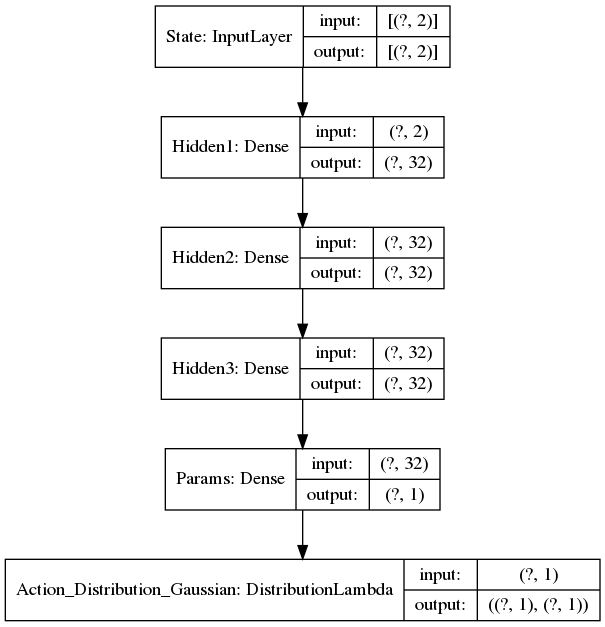

In [19]:
tf.keras.utils.plot_model(policy, show_shapes=True)

## 2. Agente REINFORCE

In [20]:
env = gym.make("CartPole-v1")
print(env.spec.reward_threshold)

475.0


### 2.1 Calculando retornos de episódios

$$
\hat{R}_t = \sum_{t'=t}^T r_{t'}
$$

In [21]:
def compute_returns(rewards):
    n_episodes = len(rewards)

    returns = []

    for episode in range(n_episodes):
        episode_returns = []
        total_reward = 0.0

        for i in range(len(rewards[episode]) - 1, -1, -1):
            reward = rewards[episode][i]
            total_reward += reward
            episode_returns.append(total_reward)
        
        episode_returns = episode_returns[::-1]
        returns.append(np.array(episode_returns))

    return returns

In [22]:
n_episodes, batch_size = 32, 20
rewards = np.random.uniform(size=[n_episodes, batch_size])

returns = compute_returns(rewards)

assert len(returns) == n_episodes
assert all(np.allclose(np.cumsum(rewards[i][::-1])[::-1], returns[i]) for i in range(n_episodes))

### 2.2 Implementação do *surrogate loss*: combinando log-prob e retornos 

$$
\nabla_\theta J(\theta) = \mathbb{E}_{\tau \sim \pi_\theta} \left [ \sum_{t=0}^T \nabla_\theta \log \pi_\theta(\mathbf{a}_t|\mathbf{s}_t) \hat{R}_t\right ]
$$

In [23]:
class REINFORCE(RLAgent):
    
    def __init__(self, obs_space, action_space, config=None):
        super(REINFORCE, self).__init__(obs_space, action_space, config)
        
        self._build_memory()
        self._build_policy()
        self._build_optimizer()
        
    def _build_memory(self):
        self.memory = OnPolicyReplay()
        
    def _build_policy(self):
        if isinstance(self.action_space, gym.spaces.discrete.Discrete):
            self.policy = build_discrete_policy(self.obs_space, self.action_space, config["hidden_layers"], config["activation"])
        else:
            self.policy = build_continuous_policy(self.obs_space, self.action_space, config["hidden_layers"], config["activation"])

    def _build_optimizer(self):
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

    def act(self, obs):
        return self._act(obs).numpy()
    
    @tf.function
    def _act(self, obs):
        action_dist = self.policy(obs[None,:])
        return action_dist.sample()[0]

    def observe(self, obs, action, reward, next_obs, done):
        self.memory.update(obs, action, reward, next_obs, done)

    def learn(self):
        if self.memory.batch_size < 3000:
            return
        
        batch = self.memory.sample()

        weights = self.policy.trainable_weights

        with tf.GradientTape() as tape:
            loss = self._loss_fn(batch)
            gradients = tape.gradient(loss, weights)

        self.optimizer.apply_gradients(zip(gradients, weights))
      
        return loss
    
    def _loss_fn(self, batch):
        states, actions, rewards = batch["states"], batch["actions"], batch["rewards"]
        returns = compute_returns(rewards)
        
        n_episodes = len(states)

        loss = 0.0
        for episode in range(n_episodes):
            action_dist = self.policy(states[episode])
            log_prob = action_dist.log_prob(actions[episode])
            
            G = returns[episode]
            G = (G - np.mean(G)) / (np.std(G) if np.std(G) > 0 else 1)
            loss += - tf.reduce_sum(log_prob * G)

        loss /= n_episodes
            
        return loss

In [24]:
config = {
    "hidden_layers": [64, 64],
    "activation": "elu"
}

agent = REINFORCE(env.observation_space, env.action_space, config=config)

## 3. Treinamento do agente

In [25]:
total_timesteps = 500_000

timesteps = []
total_rewards = []
avg_total_rewards = []


timestep = 0
episode = 0

while timestep < total_timesteps:
    total_reward = 0.0
    episode_length = 0

    obs = env.reset()

    done = False
    
    while not done:
        action = agent.act(obs)
        next_obs, reward, done, _  = env.step(action)
        agent.observe(obs, action, reward, next_obs, done)
    
        total_reward += reward
        episode_length += 1

        timestep += 1

        obs = next_obs
    
    timesteps.append(timestep)
    total_rewards.append(total_reward)
    avg_total_rewards.append(np.mean(total_rewards[-100:]))
        
    episode += 1
    
    loss = agent.learn()

    if loss is not None:
        print(f"timestep = {timestep}/{total_timesteps}, episode = {episode:3d} -> loss = {loss:10.4f}, total_reward = {total_reward:10.4f}, episode_length = {episode_length:3d}\r", end="")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [26]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.layouts import row

output_notebook()

p1 = figure(
    title="Avg Returns",
    x_axis_label="Episodes",
    plot_width=600,
    plot_height=400
)
p1.line(timesteps, avg_total_rewards)

p2 = figure(
    title="Returns",
    x_axis_label="Episodes",
    plot_width=600,
    plot_height=400
)
p2.line(timesteps, total_rewards)

show(row([p1, p2]))

Loading BokehJS ...

## 4. Experimentos 